In [1]:
import pandas as pd
import numpy as np


dates_df = pd.read_csv(
    'hep-th-slacdates_unzipped.txt', 
    sep=' ', 
    header=None, 
    names=['id_paper', 'slac_date']
)
dates_df['slac_date'] = pd.to_datetime(dates_df['slac_date'])

df_citations = pd.read_csv(
    'hep-th-citations_unzipped.txt', 
    sep=' ', 
    header=None, 
    names=['id_from', 'id_to']
)

df = pd.merge(
    df_citations, 
    dates_df, 
    how="left", 
    left_on='id_from', 
    right_on='id_paper'
)

df = pd.merge(
    df, 
    dates_df, 
    how="left", 
    left_on='id_to', 
    right_on='id_paper'
).rename(
    columns={
        "slac_date_x": "date_from", 
        "slac_date_y": "date_to"
    }, 
).drop(
    columns=['id_paper_x', 'id_paper_y']
)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352807 entries, 0 to 352806
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id_from    352807 non-null  int64         
 1   id_to      352807 non-null  int64         
 2   date_from  352807 non-null  datetime64[ns]
 3   date_to    352807 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 13.5 MB
None


,id_from,id_to,date_from,date_to
0,1001,9304045,2000-01-04,1993-04-13
1,1001,9308122,2000-01-04,1993-08-30
2,1001,9309097,2000-01-04,1993-09-24
3,1001,9311042,2000-01-04,1993-11-12
4,1001,9401139,2000-01-04,1994-02-04


In [2]:
df = df[df['date_from']>=df['date_to']]
len(df)

351763

count    351763.000000
mean        782.424416
std         760.651407
min           0.000000
25%         220.000000
50%         540.000000
75%        1113.000000
max        9435.000000
Name: days_between, dtype: float64


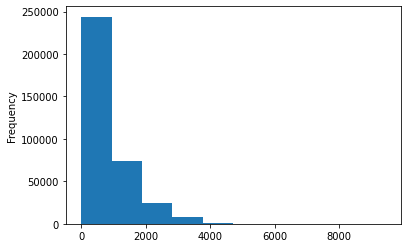

In [3]:
df['days_between'] = (df['date_from'] - df['date_to']).dt.days

print(df['days_between'].describe())
df['days_between'].plot(kind='hist')

In [22]:
citations_per_paper = df.groupby('id_to')[['id_from']].nunique().rename(
    columns={"id_from": "entire_period"}
)
citations_per_paper.append(uncited['entire_period'])

citations_per_paper['first_90_days'] = df[
    df['days_between']<=90
].groupby('id_to')['id_from'].nunique()

citations_per_paper['first_180_days'] = df[
    df['days_between']<=180
].groupby('id_to')['id_from'].nunique()

citations_per_paper['first_365_days'] = df[
    df['days_between']<=365
].groupby('id_to')['id_from'].nunique()

citations_per_paper['first_730_days'] = df[
    df['days_between']<=730
].groupby('id_to')['id_from'].nunique()


uncited = df[~df['id_from'].isin(df['id_to'])].groupby('id_from').count()
uncited['entire_period'] = 0
uncited['first_90_days'] = 0
uncited['first_180_days'] = 0
uncited['first_365_days'] = 0
uncited['first_730_days'] = 0
citations_per_paper = pd.concat([
    citations_per_paper,
    uncited[[
        'entire_period',
        'first_90_days',
        'first_180_days',
        'first_365_days',
        'first_730_days',
    ]],
])

citations_per_paper.fillna(0, inplace=True)

print(citations_per_paper.describe())
citations_per_paper.head()

       entire_period  first_90_days  first_180_days  first_365_days  \
count   27750.000000   27750.000000    27750.000000    27750.000000   
mean       12.676144       1.429622        2.667027        4.811820   
std        39.811391       3.510008        6.274831       11.523526   
min         0.000000       0.000000        0.000000        0.000000   
25%         1.000000       0.000000        0.000000        0.000000   
50%         4.000000       0.000000        1.000000        1.000000   
75%        12.000000       1.000000        3.000000        5.000000   
max      2414.000000      96.000000      206.000000      405.000000   

       first_730_days  
count    27750.000000  
mean         7.647171  
std         20.102127  
min          0.000000  
25%          1.000000  
50%          2.000000  
75%          7.000000  
max       1000.000000  


,entire_period,first_90_days,first_180_days,first_365_days,first_730_days
1001,10,0.0,1.0,4.0,7.0
1002,43,16.0,23.0,35.0,43.0
1003,15,9.0,13.0,14.0,15.0
1004,1,1.0,1.0,1.0,1.0
1005,1,0.0,0.0,1.0,1.0


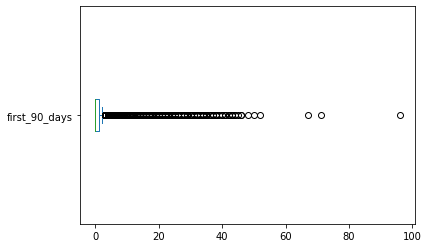

In [23]:
citations_per_paper['first_90_days'].plot(kind='box', vert=False)

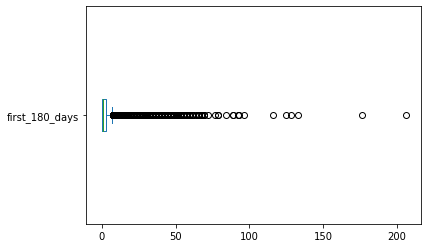

In [24]:
citations_per_paper['first_180_days'].plot(kind='box', vert=False)

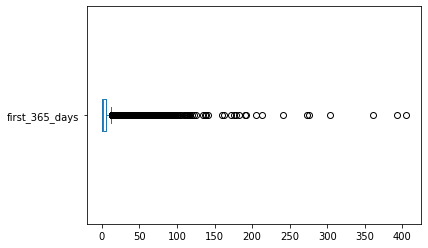

In [25]:
citations_per_paper['first_365_days'].plot(kind='box', vert=False)

In [26]:
citations_per_paper.corr()

,entire_period,first_90_days,first_180_days,first_365_days,first_730_days
entire_period,1.000000,0.554047,0.681702,0.810843,0.921380
first_90_days,0.554047,1.000000,0.938522,0.842588,0.722170
first_180_days,0.681702,0.938522,1.000000,0.949721,0.850502
first_365_days,0.810843,0.842588,0.949721,1.000000,0.952879
first_730_days,0.921380,0.722170,0.850502,0.952879,1.000000


In [27]:
pd.cut(
    citations_per_paper['first_90_days'], 
    [-1, 0, 5, 10, 96]
).value_counts()/len(citations_per_paper)

(-1, 0]     0.580396
(0, 5]      0.354811
(5, 10]     0.040541
(10, 96]    0.024252
Name: first_90_days, dtype: float64

In [28]:
pd.cut(
    citations_per_paper['first_180_days'], 
    [-1, 0, 5, 10, 206]
).value_counts()/len(citations_per_paper)

(-1, 0]      0.447207
(0, 5]       0.426270
(5, 10]      0.066054
(10, 206]    0.060468
Name: first_180_days, dtype: float64

In [29]:
pd.cut(
    citations_per_paper['first_365_days'], 
    [-1, 0, 10, 20, 405]
).value_counts()/len(citations_per_paper)

(0, 10]      0.569153
(-1, 0]      0.315063
(10, 20]     0.065189
(20, 405]    0.050595
Name: first_365_days, dtype: float64

In [30]:
citations_per_paper['label_name'] = pd.cut(
    citations_per_paper['first_365_days'], 
    [-1, 0, 10, 20, 405]
)
citations_per_paper['label'] = pd.cut(
    citations_per_paper['first_365_days'], 
    [-1, 0, 10, 20, 405]
).cat.codes

papers_label = citations_per_paper[['first_365_days', 'label', 'label_name']]
papers_label.head()

,first_365_days,label,label_name
1001,4.0,1,"(0, 10]"
1002,35.0,3,"(20, 405]"
1003,14.0,2,"(10, 20]"
1004,1.0,1,"(0, 10]"
1005,1.0,1,"(0, 10]"


In [31]:
papers_label.to_csv('papers_label.csv')